# Spam Detection

Il file .csv è il nostro dataset in cui la prima colona rappresenta il tag se la email è uno spam oppure no(spam o ham), mentre nella seconda colonna troviamo il testo della email.

Nelle altre colonne non ci sono dati che ci interessano.

In [8]:
import pandas as pd
#carichiamo il file

DATA_FILE = "spam.csv"

df = pd.read_csv(DATA_FILE, encoding='latin-1')# encoding con cui leggere i byte di quei file
print(df.head())

     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [9]:
tags = df.v1
texts = df.v2

## Preprocessing

Tokenizer consente di vettorializzare un corpus di testo (un'insieme di testi), trasformando i testi
in una sequenza di numeri interi, un vocabolario rappresentato con un dizionario Python (ogni numero intero è l'indice di un token in un dizionario, chiave: indice, valore: parola) o in un vettore in cui il coefficiente potrebbe essere binario,
basato sul conteggio delle parole, ecc...

#### Argomenti

num_words:  il numero massimo di parole da conservare, in base
            alla frequenza delle parole stesse.
filters:    una stringa in cui ogni elemento è un carattere che sarà
            filtrato dai testi. L'impostazione predefinita è tutta la punteggiatura,
            oltre a interruzioni di riga e caratteri speciali.
lower:      booleano. Se convertire i testi in minuscolo.
split:      carattere o stringa da utilizzare per la divisione del token.
char_level: se True, ogni carattere sarà trattato come un token.
oov_token:  se presente, verrà aggiunto a word_index e utilizzato per
            sostituire le parole fuori dal vocabolario durante le chiamate
            text_to_sequence

Per impostazione predefinita, tutta la punteggiatura viene rimossa, trasformando i testi in
sequenze di parole separate dallo spazio.
Queste sequenze sono quindi divise in elenchi di token che verranno indicizzati o vettorializzati.

"0" è un indice riservato che non verrà assegnato a nessuna parola.

In [10]:
# creiamo il nostro vocabolario 
from tensorflow.keras.preprocessing.text import Tokenizer
example_num_max = 5 #dimensione del vocabolario
example_tok = Tokenizer(num_words=example_num_max)

example_texts = [
    "HELLO MY WORLD",
    "MY WORLD",
    "AHAHHA WORLD",
    "AHAHHA AHAHHA"
]

example_tok.fit_on_texts(example_texts)

print(example_texts)

['HELLO MY WORLD', 'MY WORLD', 'AHAHHA WORLD', 'AHAHHA AHAHHA']


In [11]:
print("word_index      ->", example_tok.word_index) # dizionario con chiave una parola e valore l'indice di tale parola
print("document_count  ->", example_tok.document_count) # numero di documenti (testi) utilizati
print("word_docs       ->", example_tok.word_docs) # dizionario con il numero di documenti in cui compare ogni singola parola
print("word_counts      ->", example_tok.word_counts) # dizionario con parole e numero di occorrenze della parola

word_index      -> {'world': 1, 'ahahha': 2, 'my': 3, 'hello': 4}
document_count  -> 4
word_docs       -> defaultdict(<class 'int'>, {'hello': 1, 'my': 2, 'world': 3, 'ahahha': 2})
word_counts      -> OrderedDict({'hello': 1, 'my': 2, 'world': 3, 'ahahha': 3})


In [12]:
# preprocessing per la rete neurale dense
# creaimo una matrice di occorrenze che ci info circa le occorrenze delle singole parole all'interno dei documents 
example_mat_texts = example_tok.texts_to_matrix(example_texts, mode="count")
print(example_mat_texts) # le righe sono i documents (frasi)

[[0. 1. 0. 1. 1.]
 [0. 1. 0. 1. 0.]
 [0. 1. 1. 0. 0.]
 [0. 0. 2. 0. 0.]]


In [13]:
# preprocessing per la rete convolutiva
example_sequences = example_tok.texts_to_sequences(example_texts) # le frasi o documenti ma con gli indici delle parole
# example_sequences è una lista che contiene tante liste quante sono i testi
# ogni elemento di questa lista contiene non più le parole sottoforma di stringa, ma gli id presenti nel dizionario
print("texts_to_sequences   ->", example_sequences) # per le reti convolutive non va bene che gli input siano di dimesione diversa
# uniformiamo la dimesione delgi input
from tensorflow.keras.preprocessing import sequence
print("after pad_sequences  ->", sequence.pad_sequences(example_sequences, maxlen=example_num_max))
# grazie a pad_sequences rendiamo tutti i testi della stessa lunghezza

texts_to_sequences   -> [[4, 3, 1], [3, 1], [2, 1], [2, 2]]
after pad_sequences  -> [[0 0 4 3 1]
 [0 0 0 3 1]
 [0 0 0 2 1]
 [0 0 0 2 2]]


#### Andiamo ad applicare queste conoscenze al nostro dataset di email

In [16]:
num_max = 1000 #numero di parole nel vocabolario
from sklearn.preprocessing import LabelEncoder
# ci serve per convertire i tags da spam e ham in valori numerici 0 e 1
le = LabelEncoder()
tags = le.fit_transform(tags)

tok = Tokenizer(num_words=num_max)

tok.fit_on_texts(texts)

print(tok.document_count)

5572


In [22]:
print(type(texts))

<class 'pandas.core.series.Series'>


In [24]:
mat_texts = tok.texts_to_matrix(texts, mode='count')
print(mat_texts)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 3. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [25]:
print(tags[:5])
print(mat_texts[:5])

[0 0 1 0 0]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 3. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]


In [27]:
print(tags.shape, mat_texts.shape)

(5572,) (5572, 1000)


#### Creiamo una rete dense

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_simple_model():
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(mat_texts.shape[1], )))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print('Modello compilato!')
    return model

def check_model(model, x, y):
    return model.fit(x, y, batch_size=32, epochs=10, verbose=1, validation_split=0.2)

model = get_simple_model()
trained_model = check_model(model, mat_texts, tags)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 256)                 │         256,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 322,305 (1.23 MB)

 Trainable params: 322,305 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

Modello compilato!
Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9121 - loss: 0.2869 - val_accuracy: 0.9839 - val_loss: 0.0565
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9922 - loss: 0.0270 - val_accuracy: 0.9857 - val_loss: 0.0659
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9962 - loss: 0.0083 - val_accuracy: 0.9865 - val_loss: 0.0737
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9993 - loss: 0.0040 - val_accuracy: 0.9857 - val_loss: 0.0817
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9993 - loss: 0.0039 - val_accuracy: 0.9874 - val_loss: 0.0960
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9997 - loss: 0.0027 - val_accuracy: 0.9865 - val_loss: 0.1011
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9996 - loss: 0.0015 - val_accuracy: 0.9857 - val_loss: 0.1029
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9997 - loss: 0.0020

#### Creiamo una rete convolutiva

In [38]:
# preprocessing per le CNN

max_len = 100

# convertiamo i testi delle email in sequenze di numeri corrisponsendi agli id delle parole che formano la email prese dal vocabolario
cnn_texts_sequences = tok.texts_to_sequences(texts)
print(cnn_texts_sequences[:1])
print(texts[0])

[[50, 469, 841, 751, 657, 64, 8, 89, 121, 349, 147, 67, 58, 144]]
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


In [40]:
# dobbiamo fare il padding delle sequencies in modo da uniformare le dimesioni
cnn_texts_mat = sequence.pad_sequences(cnn_texts_sequences, maxlen=max_len)
print(cnn_texts_mat[0])
print(cnn_texts_mat.shape)

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0  50 469 841 751
 657  64   8  89 121 349 147  67  58 144]
(5572, 100)


Prima di dare in pasto i nostri vettori alla convoluzione dobbiamo fare l'Embedding che trasforma dei vettori di interi in vettori pesati di dimensione fissa, fa una pesatura dei vettori.

In [43]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

def get_cnn_model():
    model = Sequential()
    model.add(Embedding(
        1000, #dimensione del vocabolario
        100, #dimensione dei vettori in uscita
        input_shape=(cnn_texts_mat.shape[1],)
    ))
    model.add(Conv1D(
        128, 
        3,
        padding='valid',
        activation='relu',
        strides=1
    ))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cnn_model = get_cnn_model()
cnn = check_model(cnn_model, cnn_texts_mat, tags)


C:\Users\felip\OneDrive\Desktop\DataScience StarterKit\project-a\venv\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 100)            │         100,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 98, 128)             │          38,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,809 (671.13 KB)

 Trainable params: 171,809 (671.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8784 - loss: 0.3780 - val_accuracy: 0.9821 - val_loss: 0.0505
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9893 - loss: 0.0354 - val_accuracy: 0.9830 - val_loss: 0.0511
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9957 - loss: 0.0163 - val_accuracy: 0.9839 - val_loss: 0.0587
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9982 - loss: 0.0069 - val_accuracy: 0.9848 - val_loss: 0.0583
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9996 - loss: 0.0028 - val_accuracy: 0.9865 - val_loss: 0.0563
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9998 - loss: 0.0014 - val_accuracy: 0.9848 - val_loss: 0.0695
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9996 - loss: 0.0015 - val_accuracy: 0.9848 - val_loss: 0.0681
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9998 - loss: 8.9723e-04 - val_accuracy

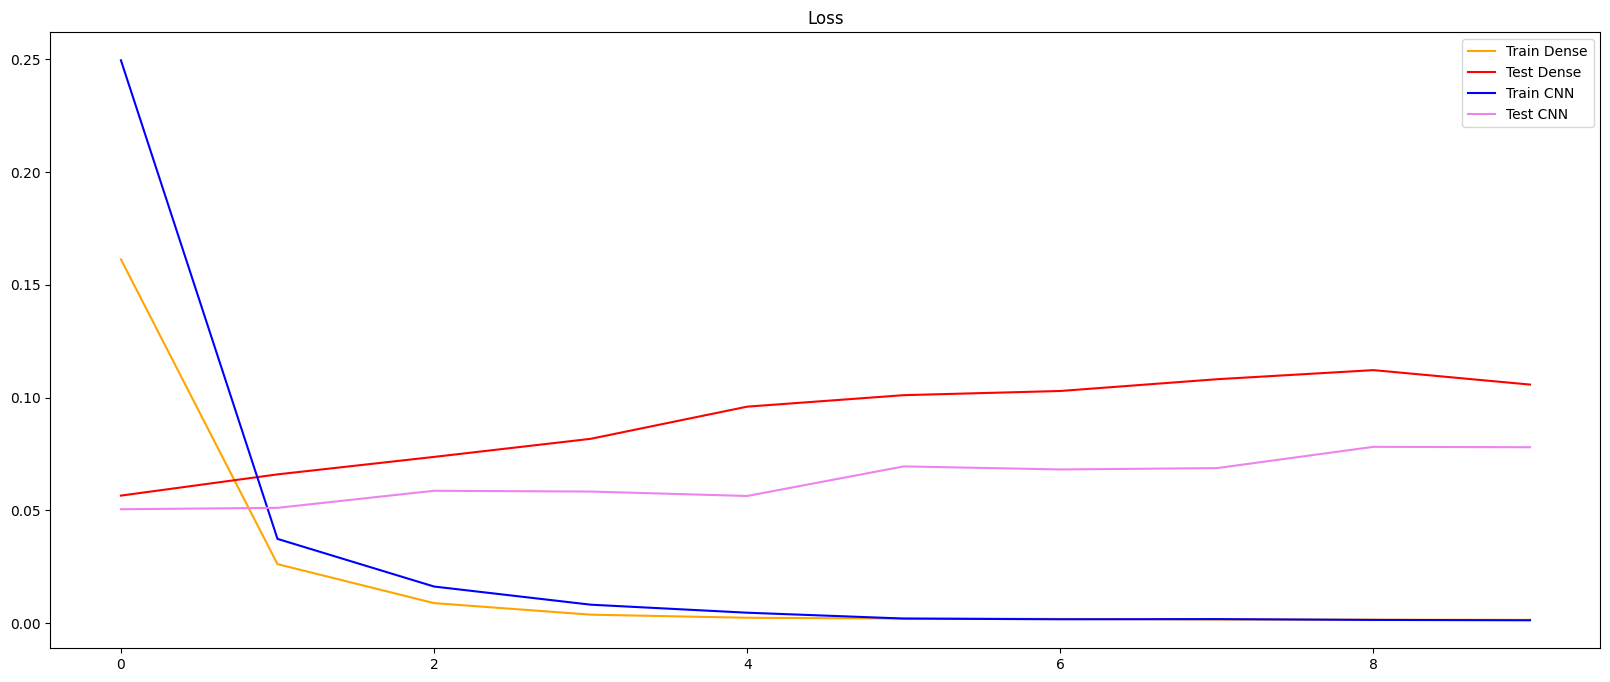

In [48]:
# vediamo i grafici
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plt.plot(model.history.history['loss'], color='orange', label='Train Dense')
plt.plot(model.history.history['val_loss'], color='red', label='Test Dense')
plt.plot(cnn_model.history.history['loss'], color='blue', label='Train CNN')
plt.plot(cnn_model.history.history['val_loss'], color='violet', label='Test CNN')
plt.title('Loss')
plt.legend()
plt.show()

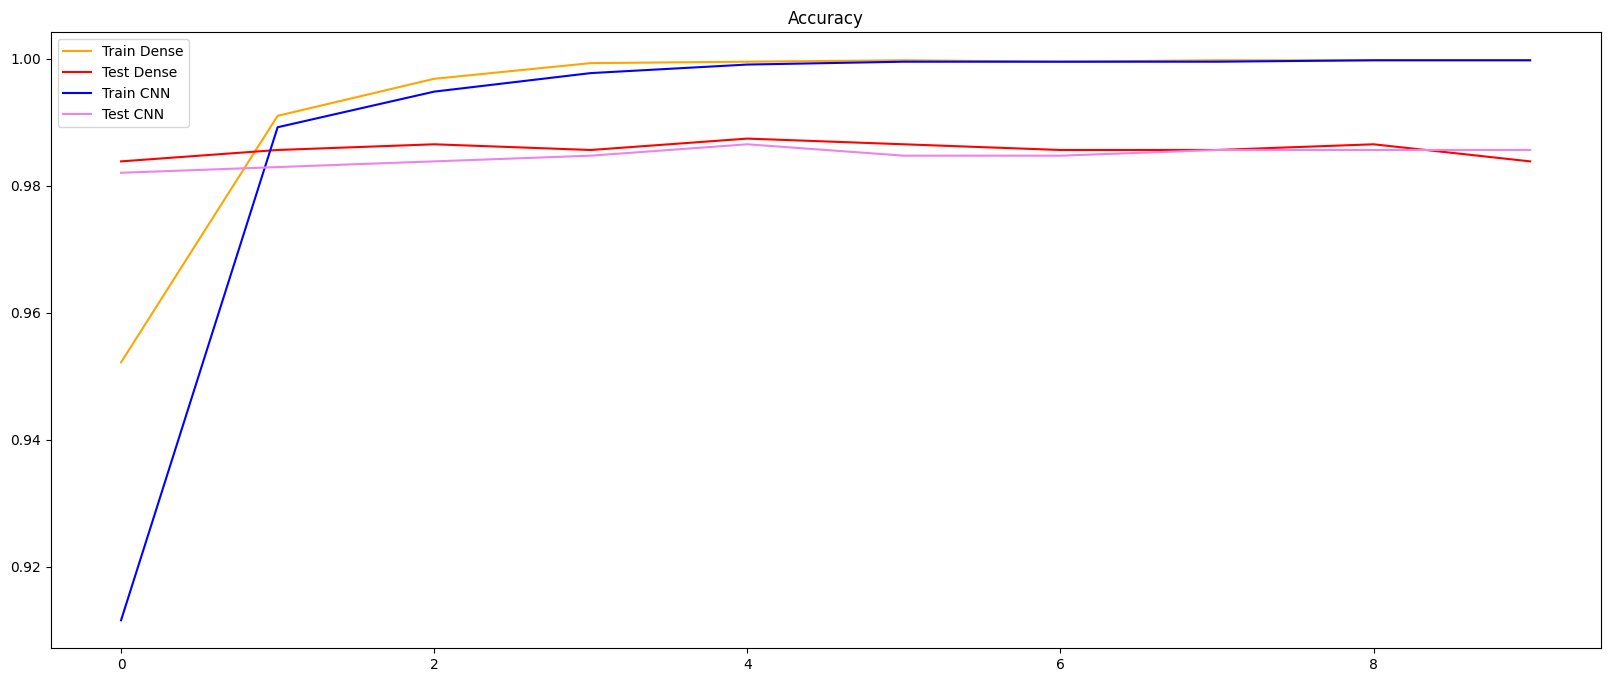

In [49]:
plt.figure(figsize=(20, 8))
plt.plot(model.history.history['accuracy'], color='orange', label='Train Dense')
plt.plot(model.history.history['val_accuracy'], color='red', label='Test Dense')
plt.plot(cnn_model.history.history['accuracy'], color='blue', label='Train CNN')
plt.plot(cnn_model.history.history['val_accuracy'], color='violet', label='Test CNN')
plt.title('Accuracy')
plt.legend()
plt.show()

A quasi parità di loss e di accuracy per i due modelli, il modello convolutivo ha soltanto 171,809 paramentri contro i 322,305 della rete dense. Perciò la CNN è molto più conveniente per le risorse poichè ha meno parametri da addestrare.